In [184]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import pyogrio
import pyvis.network as py_network
from collections import Counter
import plotly.graph_objects as go
import pickle
import torch
import torch.nn.functional as F
import torch.nn as nn
#from torch.nn import Module
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt
from itertools import product
import json
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from collections import defaultdict

In [2]:
gdf_counties = gpd.read_file("../data/pdfm_embeddings/v0/us/county.geojson", engine = "pyogrio")
gdf_zip = gpd.read_file("../data/pdfm_embeddings/v0/us/zcta.geojson", engine= "pyogrio")
gdf_dc_blocks = gpd.read_file("../data/pdfm_embeddings/v0/us/ScenarioPaint.geojson", engine="pyogrio")

In [3]:
common_crs = gdf_counties.crs
gdf_zip = gdf_zip.to_crs(common_crs)
gdf_dc_blocks = gdf_dc_blocks.to_crs(common_crs)

In [4]:
gdf_zip['geometry_centroid'] = gdf_zip.geometry.centroid
gdf_dc_blocks['geometry_centroid'] = gdf_dc_blocks.geometry.centroid

C:\Users\KhedgikarS\AppData\Local\Temp\ipykernel_43540\395651258.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_zip['geometry_centroid'] = gdf_zip.geometry.centroid
C:\Users\KhedgikarS\AppData\Local\Temp\ipykernel_43540\395651258.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_dc_blocks['geometry_centroid'] = gdf_dc_blocks.geometry.centroid


In [5]:
gdf_counties = gdf_counties.rename(columns = {'place':'place_county'})
gdf_counties = gdf_counties.drop(columns = ['index'])
gdf_zip = gdf_zip.rename(columns = {'place':'place_zip'})
gdf_zip = gdf_zip.drop(columns = ['index'])

In [6]:
zip_in_county = gpd.sjoin(gdf_zip.set_geometry('geometry_centroid'),gdf_counties, predicate='within')[['place_county','place_zip']]
block_in_zip = gpd.sjoin(gdf_dc_blocks.set_geometry('geometry_centroid'),gdf_zip, predicate='within')[['Identifier','place_zip']]

In [ ]:
zip_in_county

In [ ]:
block_in_zip

#### Initialize Graph

In [7]:
G = nx.Graph()

In [8]:
for cid in gdf_counties['place_county']:
    G.add_node(f"county_{cid}", type='county')

for zid in gdf_zip['place_zip']:
    G.add_node(f"zip_{zid}", type='zip')
    
for bid in gdf_dc_blocks['Identifier']:
    block_id = str(bid).strip()
    G.add_node(f"block_{block_id}", type='block')

for _, row in zip_in_county.iterrows():
    county_id = str(row['place_county']).strip()
    zip_id = str(row['place_zip']).strip()
    G.add_edge(f"zip_{zip_id}", f"county_{county_id}")
    
for _, row in block_in_zip.iterrows():
    block_id = str(row['Identifier']).strip()
    zip_id = str(row['place_zip']).strip()
    G.add_edge(f"block_{block_id}", f"zip_{zip_id}")

In [9]:
dc_zip_nodes = [f"zip_{z}" for z in block_in_zip['place_zip'].unique()]
dc_block_nodes = [f"block_{b}" for b in block_in_zip['Identifier'].unique()]
dc_county_nodes = [f"county_{c}" for c in zip_in_county['place_county'].unique()]

dc_nodes = dc_zip_nodes + dc_block_nodes + dc_county_nodes

H = G.subgraph(dc_nodes).copy()

In [ ]:
# net = py_network.Network(height="800px",width="800px",notebook=True)
# net.from_nx(H)

# for node in H.nodes(data=True):
#     nid, attrs = node
#     if 'county' in nid:
#         net.get_node(nid)['color'] = 'blue'
#     elif 'zip' in nid:
#         net.get_node(nid)['color'] = 'green'
#     elif 'block' in nid:
#         net.get_node(nid)['color'] = 'red'

# net.show("graph_preview.html")

In [ ]:
# pos = nx.kamada_kawai_layout(H)

# edge_x, edge_y = [], []
# for u, v in H.edges():
#     x0, y0 = pos[u]
#     x1, y1 = pos[v]
#     edge_x += [x0, x1, None]
#     edge_y += [y0, y1, None]

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y, mode='lines', line=dict(width=0.5, color='#888'), hoverinfo='none'
# )

# node_x, node_y, node_color, node_text = [], [], [], []
# for node in H.nodes():
#     x, y = pos[node]
#     node_x.append(x)
#     node_y.append(y)
#     node_text.append(node)
#     if node.startswith('county_'):
#         node_color.append('blue')
#     elif node.startswith('zip_'):
#         node_color.append('green')
#     elif node.startswith('block_'):
#         node_color.append('red')

# node_trace = go.Scatter(
#     x=node_x, y=node_y, mode='markers', hoverinfo='text',
#     text=node_text, marker=dict(color=node_color, size=5)
# )

# fig = go.Figure(data=[edge_trace, node_trace])
# fig.update_layout(showlegend=False, hovermode='closest')
# fig.show()

In [12]:
print(G)

Graph with 48437 nodes and 44857 edges


In [13]:
print(H)

Graph with 15347 nodes and 12259 edges


In [14]:
node_types = [n.split('_')[0] for n in G.nodes()]
print(Counter(node_types))

Counter({'zip': 33120, 'block': 12209, 'county': 3108})


In [ ]:
# node_types = [
#     G.nodes[n]['type'] if 'type' in G.nodes[n] else n.split('_')[0]
#     for n in G.nodes
# ]
# counts = Counter(node_types)
# print({k: v for k, v in counts.items() if k not in ['zip', 'block', 'county']})

# suspect_nodes = [n for n in G.nodes if (
#     not n.startswith("block_") and
#     not n.startswith("zip_") and
#     not n.startswith("county_")
# )]
# print(f"Malformed nodes: {len(suspect_nodes)}")

#### Load County and Zip Embeddings

In [17]:
county_embeddings = pd.read_csv("../data/pdfm_embeddings/v0/us/county_embeddings.csv")
zip_embeddings = pd.read_csv("../data/pdfm_embeddings/v0/us/zcta_embeddings.csv")

In [18]:
county_embeddings['place'] = county_embeddings['place'].astype(str).str.strip()
zip_embeddings['place'] = zip_embeddings['place'].astype(str).str.strip()

In [19]:
county_embeddings = county_embeddings.rename(columns={'place': 'place_county'}).set_index('place_county')
zip_embeddings = zip_embeddings.rename(columns={'place': 'place_zip'}).set_index('place_zip')

In [21]:
county_cols = [col for col in county_embeddings.columns if 'feature' in col]
zip_cols = [col for col in zip_embeddings.columns if 'feature' in col]

for idx,row in county_embeddings.iterrows():
    node_id = f"county_{str(idx).strip()}"
    if node_id in G:
        values = pd.to_numeric(row[county_cols], errors='coerce').fillna(0).values
        features = torch.tensor(values, dtype=torch.float32)
        G.nodes[node_id]['features'] = features
        G.nodes[node_id]['type'] = 'county'
        
for idx,row in zip_embeddings.iterrows():
    node_id = f"zip_{str(idx).strip()}"
    if node_id in G:
        values = pd.to_numeric(row[zip_cols], errors='coerce').fillna(0).values
        features = torch.tensor(values, dtype=torch.float32)
        G.nodes[node_id]['features'] = features
        G.nodes[node_id]['type'] = 'zip'

In [24]:
missing_counties = []
for idx, row in county_embeddings.iterrows():
    node_id = f"county_{idx}"
    if node_id not in G:
        missing_counties.append(node_id)
    else:
        values = pd.to_numeric(row[county_cols], errors='coerce').fillna(0).values
        features = torch.tensor(values, dtype=torch.float32)
        G.nodes[node_id]['features'] = features
        G.nodes[node_id]['type'] = 'county'

print(f"Missing counties in G: {len(missing_counties)}")



missing_zip = []
for idx, row in zip_embeddings.iterrows():
    node_id = f"zip_{idx}"
    if node_id not in G: 
        missing_zip.append(node_id)
    else:
        values = pd.to_numeric(row[zip_cols], errors='coerce').fillna(0).values
        features = torch.tensor(values, dtype=torch.float32)
        G.nodes[node_id]['features'] = features
        G.nodes[node_id]['type'] = 'zip'
        
print(f"Missing zips in G: {len(missing_zip)}")

Missing counties in G: 0
Missing zips in G: 0


#### Empty Tensor [Iteration 1: dim(330)]

In [25]:
for node in G.nodes():
    if node.startswith('block_'):
        if 'features' not in G.nodes[node]: 
            G.nodes[node]['features'] = torch.zeros(330, dtype=torch.float32)
        G.nodes[node]['type'] = 'block'

In [26]:
sample_block = next(n for n in G.nodes if n.startswith('block_'))
print(G.nodes[sample_block]['features'].shape)  # should be: torch.Size([330])

torch.Size([330])


In [34]:
# Total number of nodes
total_nodes = len(G.nodes)

# Count nodes by feature presence and feature shape
feature_dim_counter = Counter()

for node in G.nodes:
    if 'features' in G.nodes[node]:
        shape = G.nodes[node]['features'].shape
        if isinstance(shape, torch.Size) or isinstance(shape, tuple):
            feature_dim_counter[shape[0]] += 1
        else:
            feature_dim_counter['invalid'] += 1
    else:
        feature_dim_counter['missing'] += 1

# Print summary
print(f"Total nodes in G: {total_nodes}")
print(f"Feature dimension counts:\n{feature_dim_counter}")

Total nodes in G: 47366
Feature dimension counts:
Counter({330: 47366})


In [28]:
missing_nodes = [n for n in G.nodes if 'features' not in G.nodes[n]]
from collections import Counter
missing_types = Counter([n.split('_')[0] for n in missing_nodes])
print("Missing node types:", missing_types)

Missing node types: Counter({'zip': 1051, 'county': 20})


In [29]:
missing_zips = [n.replace("zip_", "") for n in missing_nodes if n.startswith("zip_")]
missing_counties = [n.replace("county_", "") for n in missing_nodes if n.startswith("county_")]

In [30]:
zip_embeddings.index = zip_embeddings.index.astype(str).str.strip()
county_embeddings.index = county_embeddings.index.astype(str).str.strip()

In [ ]:
zip_embeddings

In [31]:
missing_zips_in_embeddings = [z for z in missing_zips if z not in zip_embeddings.index]
missing_counties_in_embeddings = [c for c in missing_counties if c not in county_embeddings.index]

print(f"ZIPs missing in embeddings: {len(missing_zips_in_embeddings)}")
print(f"Counties missing in embeddings: {len(missing_counties_in_embeddings)}")

ZIPs missing in embeddings: 1051
Counties missing in embeddings: 20


#### Removed the empty Nodes for torch-geometric 

In [ ]:
G.remove_nodes_from([n for n in G.nodes if 'features' not in G.nodes[n]])

#### Pickle for Backup

In [42]:
with open("dc_graph.pkl", "wb") as f:
     pickle.dump(G, f)

In [ ]:
with open("dc_graph.pkl", "rb") as f:
    G = pickle.load(f)

In [35]:
for node in G.nodes:
    if 'features' not in G.nodes[node]:
        print(node)

In [37]:
for n in G.nodes:
    if 'features' not in G.nodes[n] or G.nodes[n]['features'].shape[0] != 330:
        print(f"❌ Bad node: {n}")
        break

In [55]:
bad_shape_nodes = []

for n in G.nodes:
    f = G.nodes[n].get('features', None)
    if f is None:
        continue  # handled separately below
    if not isinstance(f, torch.Tensor):
        bad_shape_nodes.append((n, type(f), 'not a tensor'))
    elif f.shape != (330,):
        bad_shape_nodes.append((n, f.shape, 'wrong shape'))

print(f"❗ Nodes with invalid feature shape: {len(bad_shape_nodes)}")
if bad_shape_nodes:
    for n, shape, reason in bad_shape_nodes[:5]:
        print(f"  {n}: {shape} ({reason})")

❗ Nodes with invalid feature shape: 0


In [54]:
types = {type(G.nodes[n]['features']) for n in G.nodes if 'features' in G.nodes[n]}
print(types)  # should be: {<class 'torch.Tensor'>}

{<class 'torch.Tensor'>}


In [77]:
data = from_networkx(G, group_node_attrs=['features'])

In [83]:
print(data.x.shape)

torch.Size([47366, 330])


In [84]:
print(data.x)

tensor([[-4.5307e-02,  1.9088e+00,  1.5809e+00,  ...,  6.2893e+00,
         -6.2022e-03,  3.6888e+00],
        [-5.0006e-02,  3.1870e+00,  9.8620e-01,  ..., -1.6783e-01,
         -4.0926e-03,  4.9177e+00],
        [-8.2115e-02,  1.2409e+00,  9.7846e-01,  ...,  2.0864e-01,
         -5.6943e-02,  4.8576e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [63]:
for n in G.nodes:
    if 'features' not in G.nodes[n]:
        G.nodes[n]['features'] = torch.zeros(330)
    if 'type' not in G.nodes[n]:
        G.nodes[n]['type'] = 'unknown'

In [75]:
for n in G.nodes:
    if n.startswith("block_"):
        G.nodes[n]['type'] = 'block'
    elif n.startswith("zip_"):
        G.nodes[n]['type'] = 'zip'
    elif n.startswith("county_"):
        G.nodes[n]['type'] = 'county'
    else:
        G.nodes[n]['type'] = 'unknown'

In [80]:
type_counts = Counter(G.nodes[n].get('type', 'missing') for n in G.nodes)
print(type_counts)

Counter({'zip': 32069, 'block': 12209, 'county': 3088})


In [81]:
expected_keys = set(G.nodes[next(iter(G.nodes))].keys())
for n in G.nodes:
    if set(G.nodes[n].keys()) != expected_keys:
        print(f"Mismatch at {n}: {G.nodes[n].keys()}")
        break

Training the GraphSAGE model

In [86]:
data.edge_index.shape

torch.Size([2, 88412])

In [85]:
data.edge_index

tensor([[    0,     0,     0,  ..., 47363, 47364, 47365],
        [10701, 10720, 12139,  ..., 27259, 27139, 27139]])

In [ ]:
node_types = [G.nodes[n]['type'] for n in G.nodes]
node_type_tensor = torch.tensor([{'block': 0, 'zip': 1, 'county': 2}[t] for t in node_types])

zip_mask = node_type_tensor == 1
county_mask = node_type_tensor == 2
block_mask = node_type_tensor == 0

train_mask = zip_mask | county_mask 

In [89]:
class GraphSAGE(Module):
    def __init__(self, in_dim=330, hidden_dim=128, out_dim=330):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [92]:
model = GraphSAGE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

x_init = data.x.clone()  # Save original inputs

losses = []  # ← to store loss at each epoch

for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(x_init, data.edge_index)

    loss = F.mse_loss(out[train_mask], x_init[train_mask])
    loss.backward()
    optimizer.step()

    losses.append(loss.item())  # ⬅️ record loss
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")

Epoch 0 | Loss: 1.8299
Epoch 20 | Loss: 0.6591
Epoch 40 | Loss: 0.4964
Epoch 60 | Loss: 0.4022
Epoch 80 | Loss: 0.3480
Epoch 100 | Loss: 0.3150
Epoch 120 | Loss: 0.2895
Epoch 140 | Loss: 0.2727
Epoch 160 | Loss: 0.2646
Epoch 180 | Loss: 0.2558


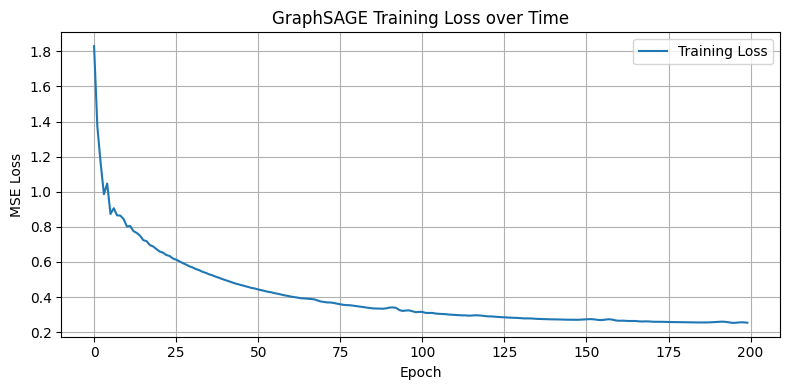

In [93]:
plt.figure(figsize=(8, 4))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('GraphSAGE Training Loss over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
losses

#### Hyperparameter Sweep Function

In [107]:
optimizers = ['Adam', 'AdamW', 'SGD']
learning_rates = [1e-3, 5e-3]
weight_decays = [1e-5, 1e-4]
hidden_dims = [64, 128]
epoch_list = [200, 500, 1000]

In [110]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, out_dim)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

def run_sweep(
    data, x_init, train_mask,
    optimizers=['Adam', 'AdamW'],
    learning_rates=[1e-3, 5e-3],
    weight_decays=[1e-5, 1e-4],
    hidden_dims=[64, 128],
    epoch_list=[100, 200],
    verbose=False, 
    return_loss_curve = False
):
    results = []
    loss_curves = {}
    best_model = None
    best_loss = float('inf')
    
    combinations = list(product(optimizers, learning_rates, weight_decays, hidden_dims, epoch_list))

    for opt_type, lr, wd, hdim, epochs in combinations:
        model = GraphSAGE(in_dim=x_init.shape[1], hidden_dim=hdim, out_dim=x_init.shape[1])
        model.train()
        
        if opt_type == 'Adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        elif opt_type == 'AdamW':
            optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
        elif opt_type == 'SGD':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
        else:
            raise ValueError(f"Unknown optimizer: {opt_type}")
        
        loss_curve = []
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = model(x_init, data.edge_index)
            loss = F.mse_loss(out[train_mask], x_init[train_mask])
            loss.backward()
            optimizer.step()
            loss_curve.append(loss.item())
        
        final_loss = loss.item()
        config_id = f"{opt_type}_lr{lr}_wd{wd}_hd{hdim}_ep{epochs}"
        loss_curves[config_id] = loss_curve
        if verbose:
            print(f"{opt_type}, lr={lr}, wd={wd}, hdim={hdim}, ep={epochs} → loss={final_loss:.4f}")
        
        results.append({
            'optimizer': opt_type,
            'lr': lr,
            'wd': wd,
            'hidden_dim': hdim,
            'epochs': epochs,
            'loss': final_loss
        })

        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model

    df = pd.DataFrame(results).sort_values(by='loss').reset_index(drop=True)

    if return_loss_curve:
        return best_model, df, loss_curves
    else:
        return best_model, df

#### Hyperparameter Sweep helps us identify what works best in terms of learning rate, weights, hidden layer dimension and epochs for learning

In [111]:
best_model, results_df, loss_curves = run_sweep(data, x_init, train_mask, optimizers, learning_rates, weight_decays, hidden_dims, epoch_list, verbose=True, return_loss_curve=True)

Adam, lr=0.001, wd=1e-05, hdim=64, ep=200 → loss=0.3652
Adam, lr=0.001, wd=1e-05, hdim=64, ep=500 → loss=0.2514
Adam, lr=0.001, wd=1e-05, hdim=64, ep=1000 → loss=0.1757
Adam, lr=0.001, wd=1e-05, hdim=128, ep=200 → loss=0.2107
Adam, lr=0.001, wd=1e-05, hdim=128, ep=500 → loss=0.1374
Adam, lr=0.001, wd=1e-05, hdim=128, ep=1000 → loss=0.1030
Adam, lr=0.001, wd=0.0001, hdim=64, ep=200 → loss=0.3312
Adam, lr=0.001, wd=0.0001, hdim=64, ep=500 → loss=0.2300
Adam, lr=0.001, wd=0.0001, hdim=64, ep=1000 → loss=0.2100
Adam, lr=0.001, wd=0.0001, hdim=128, ep=200 → loss=0.2222
Adam, lr=0.001, wd=0.0001, hdim=128, ep=500 → loss=0.1274
Adam, lr=0.001, wd=0.0001, hdim=128, ep=1000 → loss=0.1029
Adam, lr=0.005, wd=1e-05, hdim=64, ep=200 → loss=0.4000
Adam, lr=0.005, wd=1e-05, hdim=64, ep=500 → loss=0.3529
Adam, lr=0.005, wd=1e-05, hdim=64, ep=1000 → loss=0.3144
Adam, lr=0.005, wd=1e-05, hdim=128, ep=200 → loss=0.2668
Adam, lr=0.005, wd=1e-05, hdim=128, ep=500 → loss=0.2281
Adam, lr=0.005, wd=1e-05, hdi

In [112]:
results_df.to_csv("../results/model_results.csv")

In [ ]:
config_id = f"{opt_type}_lr{lr}_wd{wd}_hd{hdim}_ep{epochs}"

Index(['optimizer', 'lr', 'wd', 'hidden_dim', 'epochs', 'loss'], dtype='object')

In [117]:
results_df['config'] = results_df.apply(
    lambda row: f"{row['optimizer']}_lr{row['lr']}_wd{row['wd']}_hd{row['hidden_dim']}_ep{row['epochs']}",
    axis=1
)

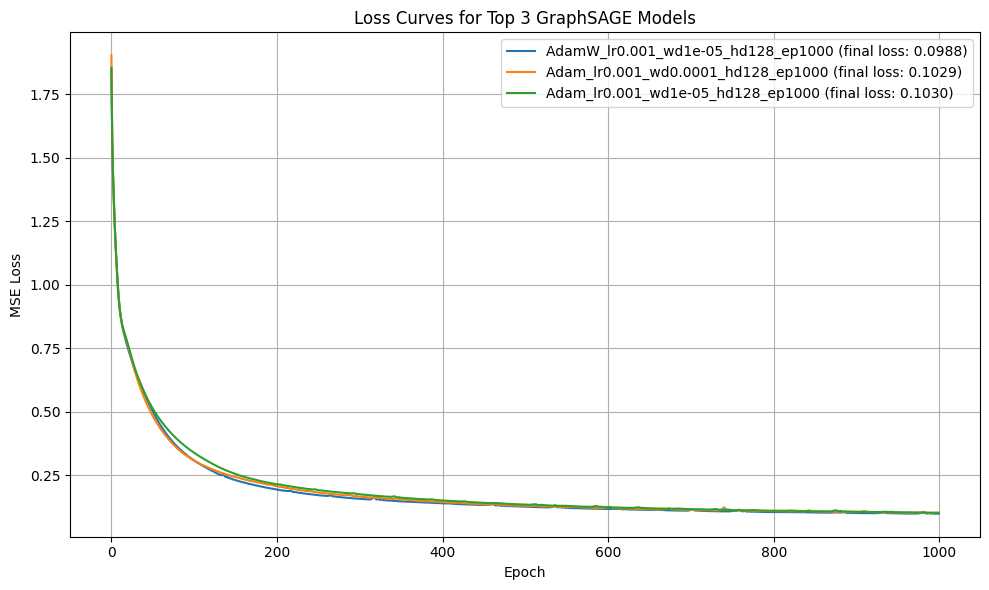

In [119]:
# Plot loss for top 3 models with final loss in legend
top_rows = results_df.sort_values(by='loss').head(3)

plt.figure(figsize=(10, 6))

for _, row in top_rows.iterrows():
    config = row['config']
    final_loss = row['loss']
    label = f"{config} (final loss: {final_loss:.4f})"
    plt.plot(loss_curves[config], label=label)

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Curves for Top 3 GraphSAGE Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Check Semantic Structure Preservation

In [120]:
out = best_model(x_init, data.edge_index)
cos_sim = F.cosine_similarity(out[train_mask], x_init[train_mask], dim=1)
print("Mean cosine similarity:", cos_sim.mean().item())

Mean cosine similarity: 0.9644116759300232


In [121]:
best_model

GraphSAGE(
  (conv1): SAGEConv(330, 128, aggr=mean)
  (conv2): SAGEConv(128, 330, aggr=mean)
)

#### Generate Embeddings from the Best Model

In [122]:
best_model.eval()
with torch.no_grad():
    final_embeddings = best_model(data.x, data.edge_index)

In [ ]:
final_embeddings

In [ ]:
node_ids = list(G.nodes) #preserved index

In [124]:
block_rows = [(i, nid) for i, nid in enumerate(node_ids) if nid.startswith('block_')]

block_indices = [i for i, _ in block_rows]
block_names = [nid for _, nid in block_rows]

block_embeddings = final_embeddings[block_indices]

In [145]:
block_df = pd.DataFrame(block_embeddings.cpu().numpy(), index=block_names)
block_df.index.name = 'Identifier'

In [ ]:
block_df

In [147]:
block_df['Identifier'] = block_df.index

In [148]:
block_df['Identifier'] = block_df['Identifier'].str.replace('block_', '', regex=False)

In [ ]:
block_df.columns = [f'feature{i}' for i in range(block_df.shape[1])]

block_df = block_df.reset_index(drop=True)

gdf_dc_embeddings = gdf_dc_to_join.merge(block_df, on="Identifier", how="left")

In [149]:
block_df = block_df.reset_index(drop=True)

In [152]:
gdf_dc_to_join = gdf_dc_blocks[['Identifier', 'geometry']]

In [153]:
gdf_dc_embeddings = gdf_dc_to_join.merge(block_df, on="Identifier", how="left")

In [157]:
gdf_dc_embeddings.to_file("../results/gdf_embeddings_dc.geojson")

In [151]:
block_df.to_csv("../results/model_results.csv")

In [ ]:
zip_embeddings

#### How well the Estimated KPIs are predicted by the embeddings?

In [159]:
with open("../data/raw/ExistingPlotKPIs.json", "r") as f:
    kpi_data = json.load(f)

In [161]:
kpi_df = pd.DataFrame(kpi_data)

In [162]:
print(kpi_df.columns)
print(kpi_df.head())

Index(['Identifier', 'PLOT', 'Acres', 'E_Pop', 'E_Jobs', 'E_Du',
       'E_Du_Affordable', 'E_Du_1', 'E_Du_2', 'E_Du_3', 'E_AccessJobs',
       'E_AccessMedical', 'E_ReachableMedical', 'E_MedicalPerCapita',
       'E_AccessGroceries', 'E_ReachableGroceries', 'E_GroceriesPerCapita',
       'E_AccessPark', 'E_ReachableParkAcres', 'E_AccessMetro',
       'E_HighFloodRisk', 'E_DispRisk', 'E_Waste', 'E_Water', 'E_Electricity',
       'E_DevCap_Homes', 'E_DevCap_Jobs'],
      dtype='object')
                 Identifier  PLOT     Acres     E_Pop    E_Jobs  E_Du  \
0  Ward 3$0008021012$PAR0$0     0  8.053902  0.000000  0.000000     0   
1  Ward 3$0008022011$PAR1$1     1  0.022496  0.249938  0.557074     3   
2  Ward 3$0008022012$PAR2$2     2  0.062865  0.964676  0.857894     4   
3  Ward 3$0008022010$PAR3$3     3  0.020196  0.000000  0.857894     0   
4  Ward 3$0008022010$PAR4$4     4  0.167806  3.349384  0.857894     4   

   E_Du_Affordable  E_Du_1  E_Du_2  E_Du_3  ...  E_AccessPark  \
0    

In [163]:
kpi_df.index

RangeIndex(start=0, stop=12209, step=1)

In [164]:
block_df.index

RangeIndex(start=0, stop=12209, step=1)

In [165]:
kpi_df = kpi_df.rename(columns={'Identifier': 'Identifier_n'})
merged_df = pd.concat([kpi_df, block_df], axis=1)


In [ ]:
merged_df

In [ ]:
kpi_cols_all = [col for col in merged_df.columns if col.startswith('E_')]

# Columns to predict - only those with non-zero values in at least one row
kpi_cols = [col for col in kpi_cols_all if merged_df[col].abs().sum() > 0]

In [168]:
embedding_cols = [col for col in merged_df.columns if col.startswith('feature')]


#### Ridge Prediction on each KPI using Embeddings

In [169]:
X = merged_df[embedding_cols].values
Y = merged_df[kpi_cols]

In [170]:
def evaluate_embedding_r2(X, Y, alpha=1.0):
    model = Ridge(alpha=alpha)
    results = []

    for kpi in Y.columns:
        y = Y[kpi].values
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)
        results.append({'KPI': kpi, 'R2': r2})

    return pd.DataFrame(results).sort_values(by='R2', ascending=False).reset_index(drop=True)

In [ ]:
r2_results = evaluate_embedding_r2(X, Y, alpha=1.0)
print(r2_results)

                     KPI        R2
0   E_GroceriesPerCapita  0.864923
1   E_ReachableGroceries  0.832021
2     E_ReachableMedical  0.826694
3     E_MedicalPerCapita  0.731823
4           E_AccessJobs  0.399920
5          E_DevCap_Jobs  0.168399
6          E_Electricity  0.144930
7                 E_Jobs  0.125662
8                E_Waste  0.111398
9   E_ReachableParkAcres  0.105674
10         E_AccessMetro  0.065128
11               E_Water  0.036873
12                E_Du_3  0.029369
13     E_AccessGroceries  0.027733
14       E_AccessMedical  0.027621
15                 E_Pop  0.027482
16          E_AccessPark  0.027480
17        E_DevCap_Homes  0.018563
18                  E_Du  0.018274
19                E_Du_2  0.017310
20                E_Du_1  0.016397
21       E_HighFloodRisk  0.012996
22       E_Du_Affordable  0.008373


#### Poor R-squares for most variables - This is expected because of Graph Topology (which will eventually calibrate)

In [178]:
def best_alpha_per_kpi(X, Y, alphas=np.logspace(-4, 1, 20)):
    results = []
    
    for kpi in Y.columns:
        y = Y[kpi].values
        best_r2 = -np.inf
        best_alpha = None

        for alpha in alphas:
            model = Ridge(alpha=alpha)
            try:
                model.fit(X, y)
                y_pred = model.predict(X)
                r2 = r2_score(y, y_pred)
                if r2 > best_r2:
                    best_r2 = r2
                    best_alpha = alpha
            except Exception as e:
                continue  # skip ill-conditioned cases silently

        results.append({
            'KPI': kpi,
            'Best_R2': best_r2,
            'Best_alpha': best_alpha
        })

    return pd.DataFrame(results).sort_values(by='Best_R2', ascending=False).reset_index(drop=True)

In [ ]:
X = merged_df[[col for col in merged_df.columns if col.startswith("feature")]].values
Y = merged_df[[col for col in merged_df.columns if col.startswith("E_") and merged_df[col].abs().sum() > 0]]

r2_per_kpi_df = best_alpha_per_kpi(X, Y)
print(r2_per_kpi_df)

In [172]:
kpi_df[kpi_cols].describe().T[['mean', 'std']]

,mean,std
E_Pop,55.047834,134.185649
E_Jobs,53.811532,379.743269
E_Du,25.089852,93.534820
E_Du_Affordable,3.040052,26.669663
E_Du_1,1.930625,17.366360
E_Du_2,18.108772,86.986854
E_Du_3,5.050455,27.602168
E_AccessJobs,0.430702,0.381027
E_AccessMedical,54.444956,132.491231
E_ReachableMedical,0.198555,0.057421


### Top 3 Similarity Ranking

In [181]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_zip_matches(block_df, zip_df, top_k=3):
    # Extract feature matrix
    block_features = block_df[[f'feature{i}' for i in range(330)]].values
    zip_features = zip_df[[f'feature{i}' for i in range(330)]].values
    
    # Normalize for cosine similarity
    block_norm = block_features / np.linalg.norm(block_features, axis=1, keepdims=True)
    zip_norm = zip_features / np.linalg.norm(zip_features, axis=1, keepdims=True)
    
    # Compute cosine similarity matrix: [n_blocks, n_zips]
    sim_matrix = cosine_similarity(block_norm, zip_norm)

    # Get top k zip indices
    top_indices = np.argsort(sim_matrix, axis=1)[:, -top_k:][:, ::-1]  # descending

    # Map zip index back to zip_id (assumed to be the index of zip_df)
    zip_ids = zip_df.index.to_numpy()
    
    # Assign top zip_ids
    block_df['rank_1'] = zip_ids[top_indices[:, 0]]
    block_df['rank_2'] = zip_ids[top_indices[:, 1]]
    block_df['rank_3'] = zip_ids[top_indices[:, 2]]
    
    return block_df

In [182]:
merged_df = get_top_zip_matches(merged_df, zip_embeddings)

In [ ]:
merged_df

1. Get variables for each zip
2. Use the variables for backprop the block embeddings
3. Improve on KPI value

In [183]:
merged_df = merged_df.merge(block_in_zip[['Identifier', 'place_zip']],on='Identifier',how='left')

In [185]:
merged_df.keys()

Index(['Identifier_n', 'PLOT', 'Acres', 'E_Pop', 'E_Jobs', 'E_Du',
       'E_Du_Affordable', 'E_Du_1', 'E_Du_2', 'E_Du_3',
       ...
       'feature325', 'feature326', 'feature327', 'feature328', 'feature329',
       'Identifier', 'rank_1', 'rank_2', 'rank_3', 'place_zip'],
      dtype='object', length=362)

In [187]:
embedding_cols = [col for col in merged_df.columns if col.startswith("feature")]
kpi_cols = [col for col in merged_df.columns if col.startswith("E_") and merged_df[col].abs().sum() > 0]

In [242]:
X = merged_df[embedding_cols].values.astype(np.float32)
Y = merged_df[kpi_cols].values.astype(np.float32)

block_ids = merged_df['Identifier'].tolist()
zip_ids = merged_df['place_zip'].tolist()

# Map ZIPs to block indices
zip_to_blocks = defaultdict(list)
for i, zip_id in enumerate(zip_ids):
    zip_to_blocks[zip_id].append(i)

In [243]:
class KPIPredictor(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [244]:
for k, v in zip_embeddings.items():
    print(f"{k}: type={type(v)}, shape={getattr(v, 'shape', None)}")
    break  # just show the first

state: type=<class 'pandas.core.series.Series'>, shape=(32069,)


In [245]:
zip_embeddings['place_zip'] = zip_embeddings.index

In [246]:
# 1. Get feature columns
zip_feature_cols = [col for col in zip_embeddings.columns if 'feature' in col]

# 2. Convert to float32 and handle NaNs
zip_embeddings[zip_feature_cols] = zip_embeddings[zip_feature_cols].apply(
    pd.to_numeric, errors='coerce'
).astype(np.float32).fillna(0)

# 3. Extract the cleaned matrix
zip_feature_matrix = zip_embeddings[zip_feature_cols].values.astype(np.float32)

In [247]:
embedding_dim = X.shape[1]
num_kpis = Y.shape[1]
num_blocks = X.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

block_embeddings = nn.Parameter(torch.tensor(X, device=device))
true_kpis = torch.tensor(Y, device=device)

zip_embeddings_tensor = {
    f"zip_{str(zip_embeddings.iloc[i]['place_zip']).strip()}": torch.tensor(
        zip_feature_matrix[i],
        dtype=torch.float32,
        device=device
    )
    for i in range(len(zip_embeddings))
}

model = KPIPredictor(embedding_dim, 128, num_kpis).to(device)
optimizer = torch.optim.Adam(list(model.parameters()) + [block_embeddings], lr=1e-3)

In [ ]:
epochs = 30000
beta = 0.1  # ZIP anchor loss weight
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()

    preds = model(block_embeddings)
    loss_kpi = F.mse_loss(preds, true_kpis)

    # Anchor block embeddings to zip average
    loss_zip = 0.0
    for zip_id, block_idxs in zip_to_blocks.items():
        if zip_id not in zip_embeddings_tensor:
            continue
        block_idx_tensor = torch.tensor(block_idxs, device=device)
        e_zip = zip_embeddings_tensor[zip_id]
        e_block_mean = block_embeddings[block_idx_tensor].mean(dim=0)
        loss_zip += F.mse_loss(e_block_mean, e_zip)

    loss_total = loss_kpi + beta * loss_zip
    loss_total.backward()
    optimizer.step()

    losses.append(loss_total.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch} | Total Loss: {loss_total.item():.4f}")

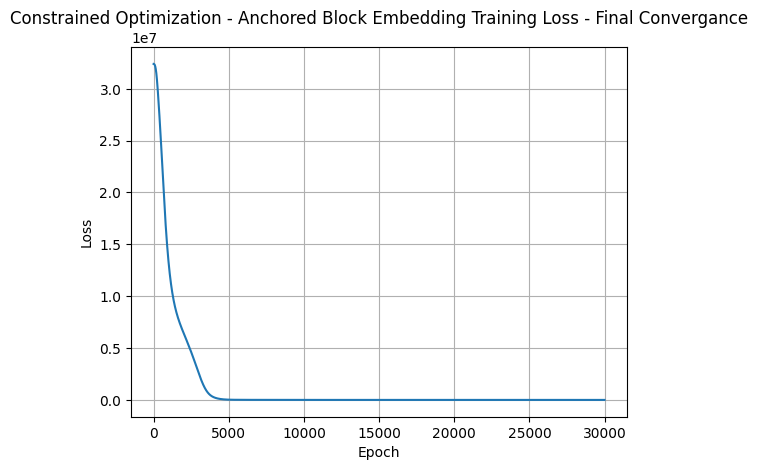

In [249]:
plt.plot(losses)
plt.title("Constrained Optimization - Anchored Block Embedding Training Loss - Final Convergance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# loss_table = []  # to store epoch-wise values

In [ ]:
# loss_table = []
# kpi_loss_curves = {kpi: [] for kpi in kpi_cols}

# for epoch in range(epochs):
#     optimizer.zero_grad()

#     preds = model(block_embeddings)
#     loss_kpi_total = F.mse_loss(preds, true_kpis)

#     # Anchor loss to ZIP-level embeddings
#     loss_zip = 0.0
#     for zip_id, block_idxs in zip_to_blocks.items():
#         if zip_id not in zip_embeddings_tensor:
#             continue
#         block_idx_tensor = torch.tensor(block_idxs, device=device)
#         e_zip = zip_embeddings_tensor[zip_id]
#         e_block_mean = block_embeddings[block_idx_tensor].mean(dim=0)
#         loss_zip += F.mse_loss(e_block_mean, e_zip)

#     loss_total = loss_kpi_total + beta * loss_zip
#     loss_total.backward()
#     optimizer.step()

#     # Every 10 epochs: log losses and KPI-specific components
#     if epoch % 10 == 0:
#         # Save total + component losses
#         loss_table.append({
#             'epoch': epoch,
#             'total_loss': loss_total.item(),
#             'kpi_loss': loss_kpi_total.item(),
#             'zip_loss': float(loss_zip)
#         })

#         # Compute per-KPI loss breakdown
#         loss_kpi_components = F.mse_loss(preds, true_kpis, reduction='none')  # [N, num_kpis]
#         per_kpi_mse = loss_kpi_components.mean(dim=0)  # [num_kpis]
#         for i, kpi in enumerate(kpi_cols):
#             kpi_loss_curves[kpi].append(per_kpi_mse[i].item())



In [ ]:
# loss_df = pd.DataFrame(loss_table)

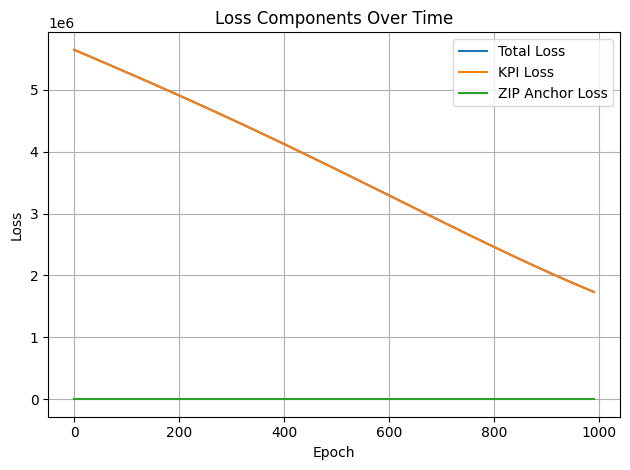

In [ ]:
# plt.plot(loss_df['epoch'], loss_df['total_loss'], label='Total Loss')
# plt.plot(loss_df['epoch'], loss_df['kpi_loss'], label='KPI Loss')
# plt.plot(loss_df['epoch'], loss_df['zip_loss'], label='ZIP Anchor Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss Components Over Time')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

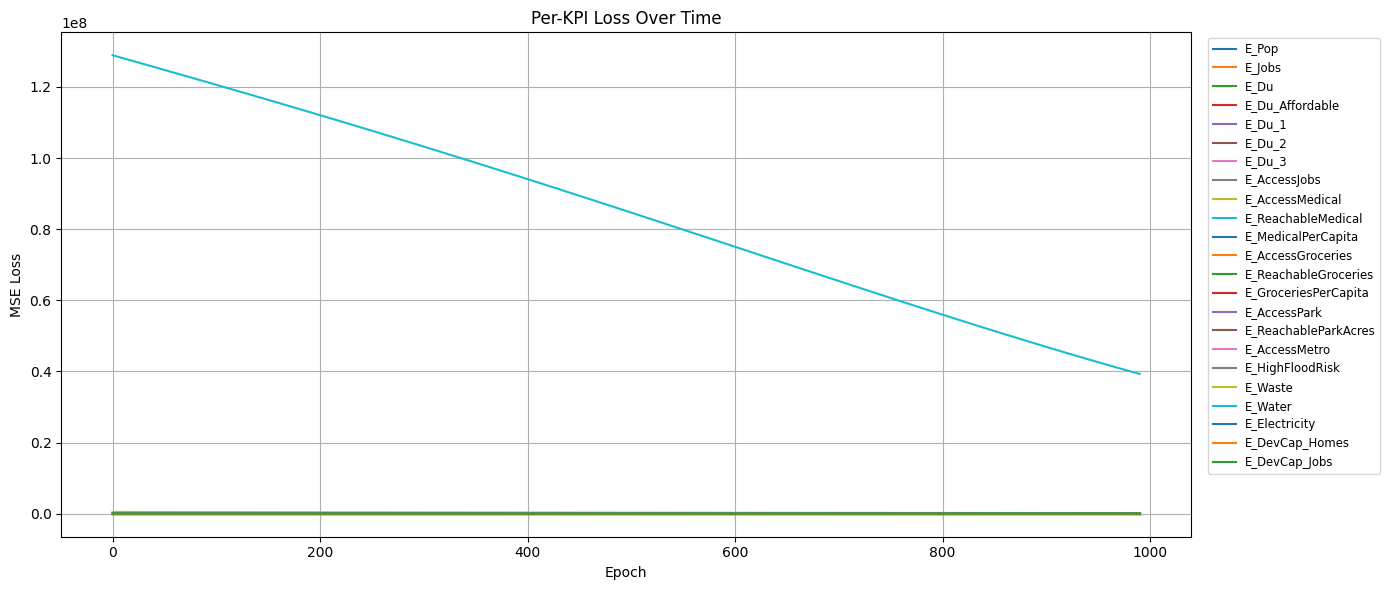

In [ ]:
# # X-axis: matching every 10 epochs
# epoch_ticks = loss_df['epoch']

# # Create the plot
# plt.figure(figsize=(14, 6))
# for kpi, losses in kpi_loss_curves.items():
#     plt.plot(epoch_ticks, losses, label=kpi)

# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('Per-KPI Loss Over Time')
# plt.legend(fontsize='small', bbox_to_anchor=(1.01, 1), loc='upper left')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
updated_block_embeddings = block_embeddings.detach().cpu().numpy()
updated_df = merged_df.copy()
for i in range(embedding_dim):
    updated_df[f'updated_embedding_{i}'] = updated_block_embeddings[:, i]

In [251]:
updated_block_embeddings

array([[ 0.04225666, -0.10423054,  0.39092058, ..., -0.3402576 ,
         0.1346975 ,  0.20447032],
       [ 0.00343331, -0.13683206,  0.4608395 , ..., -0.2790577 ,
         0.13994166,  0.17371875],
       [-0.01392414, -0.16262893,  0.46519694, ..., -0.26885924,
         0.17040792,  0.22354645],
       ...,
       [-0.211209  , -0.31198317, -0.12731743, ...,  0.57335377,
        -0.2403502 ,  0.13924643],
       [-0.00058582, -0.16998641,  0.49048594, ..., -0.19118042,
         0.17919637,  0.14919883],
       [-0.36161628, -0.08610445,  0.51095915, ..., -0.08726858,
         0.2011832 , -0.37856245]], dtype=float32)

In [252]:
# 1. Convert to DataFrame
embedding_df = pd.DataFrame(updated_block_embeddings)

# 2. Rename columns to 'feature0', 'feature1', ...
embedding_df.columns = [f'feature{i}' for i in range(embedding_df.shape[1])]

# 3. Concat with KPI DataFrame (assumes index alignment)
kpi_with_embeddings = pd.concat([kpi_df.reset_index(drop=True), embedding_df], axis=1)

In [ ]:
kpi_with_embeddings

In [254]:
X = kpi_with_embeddings[embedding_cols].values
Y = kpi_with_embeddings[kpi_cols]

In [255]:
combined_df = kpi_with_embeddings[embedding_cols + kpi_cols].dropna()

# Split again
X = combined_df[embedding_cols].values
Y = combined_df[kpi_cols]

In [258]:
r2_results = evaluate_embedding_r2(X, Y, alpha=0.5)
print(r2_results)

                     KPI        R2
0   E_GroceriesPerCapita  0.878420
1   E_ReachableGroceries  0.839121
2     E_ReachableMedical  0.832358
3     E_MedicalPerCapita  0.732888
4          E_DevCap_Jobs  0.643386
5          E_Electricity  0.530346
6   E_ReachableParkAcres  0.525388
7                E_Waste  0.474243
8                 E_Jobs  0.472853
9           E_AccessJobs  0.460366
10         E_AccessMetro  0.371854
11       E_HighFloodRisk  0.232962
12                 E_Pop  0.206519
13               E_Water  0.204991
14                E_Du_3  0.193244
15                E_Du_1  0.191979
16       E_AccessMedical  0.187812
17     E_AccessGroceries  0.187009
18          E_AccessPark  0.164381
19        E_DevCap_Homes  0.164271
20                  E_Du  0.134005
21                E_Du_2  0.123939
22       E_Du_Affordable  0.055207


In [237]:
r2_results = evaluate_embedding_r2(X, Y, alpha=1.0)
print(r2_results)

                     KPI        R2
0   E_GroceriesPerCapita  0.851442
1     E_ReachableMedical  0.816975
2   E_ReachableGroceries  0.813935
3     E_MedicalPerCapita  0.723563
4          E_DevCap_Jobs  0.583752
5          E_Electricity  0.488665
6                E_Waste  0.442773
7           E_AccessJobs  0.422929
8   E_ReachableParkAcres  0.306485
9                 E_Jobs  0.288077
10         E_AccessMetro  0.217685
11               E_Water  0.175669
12       E_HighFloodRisk  0.134674
13                 E_Pop  0.132150
14       E_AccessMedical  0.131283
15     E_AccessGroceries  0.130006
16                  E_Du  0.103846
17        E_DevCap_Homes  0.097558
18          E_AccessPark  0.092866
19                E_Du_2  0.082394
20                E_Du_3  0.067637
21                E_Du_1  0.028837
22       E_Du_Affordable  0.023671


In [238]:
print(f"Before: {len(kpi_with_embeddings)} rows")
print(f"After dropna: {len(combined_df)} rows")

Before: 12212 rows
After dropna: 12209 rows
